2D mantle convection in square box with Drucker-Prager rheology
==============================================================

In this tutorial we consider a case from [Spiegelman et al.
(2016)](https://doi.org/10.1002/2015GC006228) with a Drucker-Prager
visco-plastic rheology that depends on dynamic pressure. As this leads to
nonlinear systems that can be challenging to solve, we use this case to
illustrate some of the strategies involved in doing so within G-ADOPT.

Similar to the [visco-plastic tutorial](viscoplastic_case.md) which uses a
temperature- and depth-dependent von Mises rheology, the overall effective
viscosity takes the following form


$$\mu(\dot \epsilon, p, d) = \left(\frac{1}{\mu_1} +
\frac{1}{\mu_{\text{plast}}(\dot\epsilon, p, d)} \right)^{-1}, $$

where $\mu_1$ represents a constant linear background viscosity (not
temperature dependent in this case) and $\mu_{\text{plast}}$ is the plastic
viscosity which depends on strain rate $\dot\epsilon$, dynamic pressure $p$
and depth $d$:

$$\mu_{\text{plast}}(\dot \epsilon, p, d) = \frac{A +
B\left(p_{\text{lith}}(d) + p\right)}{2\dot\epsilon}, $$

with a depth-dependent lithostatic pressure:

$$p_{\text{lith}}(d) = \rho_0 g d $$


We start by setting a number of constants that are defined in [Spiegelman et
al. (2016)](https://doi.org/10.1002/2015GC006228), where we use velocity
$U_0$, depth $H$ and viscosity $\mu_0$ to non-dimensionalise the equations.

In [1]:
from gadopt import *
H = 30e3
year = 86400*365
U0 = Constant(5e-3/year)
mu0 = 1e22
mu1 = Constant(1e23/mu0)  # upper layer background viscosity
mu2 = Constant(1e21/mu0)  # lower layer viscosity (noting that it is isoviscous)

g = Constant(9.81)
rho0 = Constant(2700)
# Drucker-Prager coefficients:
phi = Constant(30/180*pi)  # friction angle
C = Constant(1e8/(mu0*U0/H))  # Cohesion coeffficient
A = Constant(C*cos(phi))
B = Constant(sin(phi))
alpha = Constant(1)

In these non-dimensional units our domain is a 4 x 1 rectangular box.

In [2]:
nx, ny = 128, 64   # resolution (n/o cells) in x and y direction
mesh = RectangleMesh(nx, ny, 4, 1, quadrilateral=True)  # generate rectangular mesh
mesh.cartesian = True
boundary = get_boundary_ids(mesh)

As with our previous tutorials, we set up function spaces for a Q2-Q1 discretisation for velocity
and pressure, and define a combined "mixed" solution function z.

In [3]:
V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space.
v, w = TestFunctions(Z)
z = Function(Z)  # Field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p

The viscosity is divided into two layers, scaled by $\mu_1$ and $\mu_2$
respectively, with an interface depth of $H_1$. In the middle of the domain,
there is small notch in the upper layer of width $w$, and height $h$, i.e.
the interface depth is $H_1-h$ over a width of $w$. In the description of
Spiegelman et al. (2016), this notch is also rounded with rounded corners of
radius $r$. Note however, that we do not really have sufficiently resolution
to resolve these in the current configuration.

In [4]:
H1 = 0.75
r, h, ww = 0.02, 1/12, 1/6

X = SpatialCoordinate(mesh)
x = X[0]
d = 1 - X[1]  # depth: d=0 at top and d=1 at bottom

dx0 = abs(x-2)
# interface depth at H1, except at the notch where it is H1-h:
interface_depth = H1 - conditional(dx0 < ww/2, h, 0)
dx1 = ww/2 + r - dx0
interface_depth += conditional(And(dx1 > 0, dx1 < r), sqrt(r**2-dx1**2)-r, 0)
dx2 = dx0 - (ww/2 - r)
interface_depth -= conditional(And(dx2 > 0, dx2 < r), sqrt(r**2-dx2**2)-r, 0)

We also need to define the lithostatic pressure using the formula above, but
converted to non-dimensional units: as `d` is already non-dimensional, `d*H`
is the dimensional depth, and we divide by the the pressure scale `U0*mu0/H`
to get the non-dimensional lithostatic pressure.

In [5]:
plith = g*rho0*d*H / (U0*mu0/H)

We now have everything to define the viscosity. We do this in a particular
way that will prove useful later on:
* we introduce a switch which, when its value is 1, produces the
Drucker-Prager viscosity as described above. However, if we assign a value of
0 to the switch, the viscosity changes to isoviscous with value `mu1`.
* We use a python function to supply the second invariant of the strain rate
epsii and dynamic pressure p. This is because we will later on need a version
of the viscosity defined using different Firedrake Functions than we have
defined here.

In [6]:
switch = Constant(1.)
def eta(epsii, p):  # noqa: E302
    mu_plast = (A + B*(plith + alpha*p))/(2*epsii)
    # we rewrite mu1_eff = 1/(1/mu1 + 1/mu_plast) multiplying nominator and
    # denominator with mu1*mu_plast
    mu1_eff = conditional(switch > 0.5, mu1*mu_plast/(mu1+mu_plast), mu1)
    mu1_eff = max_value(mu1_eff, mu2)
    return conditional(d < interface_depth, mu1_eff, mu2)

For now, however, we simply us the second invariant of strain rate and pressure
based on the already defined `u` and `p`

In [7]:
eps = sym(grad(u))  # noqa: E305
epsii = sqrt(0.5*inner(eps, eps))
mu = eta(epsii, p)

As with our previous tutorials, we now define an approximation and boundary conditions and set up
the solver. The boundary condition at the top is a free stress condition
(the default), with a free slip boundary condition ${\bf u}\cdot{\bf n}=0$ at the bottom. The left
and right boundaries both have a prescribed Dirichlet inflow condition of
${\bf u}\cdot{\bf n}=-U_0$, or ${\bf u}\cdot{\bf n}=-1$ in non-dimensional
units. In terms of the x-component of velocity this means a value of 1 and -1
respectively for the left and right boundaries.

In [8]:
approximation = BoussinesqApproximation(0, mu=mu)
bcs = {
    boundary.left: {'ux': 1},
    boundary.right: {'ux': -1},
    boundary.bottom: {'uy': 0}
}

newton_solver = StokesSolver(
    z,
    approximation,
    bcs=bcs,
)

Given a nonlinear system of equations, as we have set up here, the
default solver configuration of G-ADOPT means we will be solving
the discretised equations using Newton's method. When try this solve
however, we notice that the Newton iteration does not converge:

In [9]:
try:
    newton_solver.solve()
    # Catch not-converged exception and print backtrace, so we can still run through the code.
except ConvergenceError:
    import traceback
    print(traceback.format_exc())

Traceback (most recent call last):
  File "/tmp/ipykernel_21203/578091413.py", line 2, in <module>
    newton_solver.solve()
  File "/__w/g-adopt/g-adopt/.venv/lib/python3.12/site-packages/gadopt/stokes_integrators.py", line 437, in solve
    self.solver.solve()
  File "petsc4py/PETSc/Log.pyx", line 250, in petsc4py.PETSc.Log.EventDecorator.decorator.wrapped_func
  File "petsc4py/PETSc/Log.pyx", line 251, in petsc4py.PETSc.Log.EventDecorator.decorator.wrapped_func
  File "/opt/firedrake/firedrake/adjoint_utils/variational_solver.py", line 108, in wrapper
    out = solve(self, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/firedrake/firedrake/variational_solver.py", line 398, in solve
    solving_utils.check_snes_convergence(self.snes)
  File "/opt/firedrake/firedrake/solving_utils.py", line 128, in check_snes_convergence
    raise ConvergenceError(r"""Nonlinear solve failed to converge after %d nonlinear iterations.
firedrake.exceptions.ConvergenceError: Nonlinear solve failed 

Picard Solver
-------------
Instead of using Newton's algorithm to solve the nonlinear system, we try a
so called Picard iteration approach. This means that we linearize the system
based on our understanding of the physics. For the Stokes system we fix a
best guess (or value from the previous iteration) $u_{\text{Picard}}$ and
$p_{\text{Picard}}$ for velocity and pressure, and solve

$$ -\nabla\cdot \mu\left(u_{\text{Picard}}, p_{\text{Picard}}\right)
\left[\nabla u + \nabla u^T\right] + \nabla p = 0 $$

for a new u and p. Note that we're now effectively dealing with a _linear_
viscosity which does not depend on the $u$ and $p$ we are solving for. We now
solve this linear system in an iterative loop, in each iteration substituting
$u_{\text{Picard}}$ and $p_{\text{Picard}}$ with the value of $u$ and $p$ we
solved in the previous iteration. Assuming the values of $u$ and $p$ converge
between iterations - this is not guaranteed! - and thus $u_{\text{Picard}}\to
u$ and $p_{\text{Picard}}\to p$, we converge to the original nonlinear system
we wanted to solve. It is therefore important to monitor the change in values
of $u$ and $p$ in subsequent iterations.

To construct this Picard solver, we simply define another solver but now
using a viscosity that depends on `u_picard` and `p_picard` that we will
update between iterations.

In [10]:
z_picard = Function(Z)  # lagged Picard solution
u_picard, p_picard = split(z_picard)  # usual split in velocity and pressure

# viscosity expression in terms of u and p
eps_picard = sym(grad(u_picard))
epsii_picard = sqrt(0.5*inner(eps_picard, eps_picard))
mu_picard = eta(epsii_picard, p_picard)

approximation_picard = BoussinesqApproximation(0, mu=mu_picard)
bcs = {boundary.left: {'ux': 1}, boundary.right: {'ux': -1}, boundary.bottom: {'uy': 0}}

picard_solver = StokesSolver(
    z,  # note we're still solving into the same u,p as before
    approximation_picard,
    bcs=bcs
)

There is still one problem, we do not have a very good "best guess" for
`u_picard` and `p_picard` in the first iteration. In fact, if we start with a
zero velocity (as we usually do), the second invariant is also zero, and you
can see in the formulae above that we are dividing by zero. As a workaround,
we first do a separate iteration in which we simply replace the viscosity by
the constant background value `mu1`. As we saw above, we can do this by
assigning a value of 0 to the switch - without needing to redefine the solver
again.

In [11]:
switch.assign(0.)  # switch to mu=mu1
picard_solver.solve()

So far so good, but now only we have solution $(u, p$) for the wrong
rheology (namely $\mu=\mu_1$). To solve the equations with the actual
Drucker-Prager rheology, we put the switch back to 1.0, and perform the
Picard iteration. The assignment at the start of the iteration, copies the
values of $u$ and $p$, that we have just solved, into $u_{\text{Picard}}$ and
$p_{\text{Picard}}$ to be used in the viscosity in this iteration. We
calculate how much the values of $u$ and $p$ change between iterations and
decide when to quit.

In [12]:
switch.assign(1.)  # switch back to Drucker-Prager
for i in range(50):
    z_picard.assign(z)
    picard_solver.solve()
    u_change, p_change = norm(u-u_picard), norm(p-p_picard)
    print(f"In iteration {i}, L2 norm difference in u, and p between iterations:", u_change, p_change)
    if u_change < 1e-5 and p_change < 1e-5:
        break

In iteration 0, L2 norm difference in u, and p between iterations: 0.007664113004927052 8.928329099133565


In iteration 1, L2 norm difference in u, and p between iterations: 0.009873795272806445 1.481967402620548


In iteration 2, L2 norm difference in u, and p between iterations: 0.007176313395209705 0.32424103453307507


In iteration 3, L2 norm difference in u, and p between iterations: 0.004539224506136584 0.08073448002550457


In iteration 4, L2 norm difference in u, and p between iterations: 0.0027983452123809312 0.022202588033428554


In iteration 5, L2 norm difference in u, and p between iterations: 0.0017259703245926464 0.007116856906568551


In iteration 6, L2 norm difference in u, and p between iterations: 0.0010716888345103646 0.0030463043366109185


In iteration 7, L2 norm difference in u, and p between iterations: 0.0006705390533452875 0.0017267419332174477


In iteration 8, L2 norm difference in u, and p between iterations: 0.000422575344636545 0.0011049415002495975


In iteration 9, L2 norm difference in u, and p between iterations: 0.0002680158030592024 0.0007312087217754413


In iteration 10, L2 norm difference in u, and p between iterations: 0.00017093409113032488 0.0004880693325042486


In iteration 11, L2 norm difference in u, and p between iterations: 0.00010953980980500414 0.0003265538599403093


In iteration 12, L2 norm difference in u, and p between iterations: 7.048423514735409e-05 0.00021867011301005584


In iteration 13, L2 norm difference in u, and p between iterations: 4.551239961882828e-05 0.00014650402824705584


In iteration 14, L2 norm difference in u, and p between iterations: 2.947557716984766e-05 9.820946658344458e-05


In iteration 15, L2 norm difference in u, and p between iterations: 1.9138093499068275e-05 6.588143792392655e-05


In iteration 16, L2 norm difference in u, and p between iterations: 1.2453038043690298e-05 4.423339891726839e-05


In iteration 17, L2 norm difference in u, and p between iterations: 8.118064974004991e-06 2.9729290687541766e-05


In iteration 18, L2 norm difference in u, and p between iterations: 5.300428617856842e-06 2.0004588507112627e-05


In iteration 19, L2 norm difference in u, and p between iterations: 3.4653648611977634e-06 1.3478543612145655e-05


In iteration 20, L2 norm difference in u, and p between iterations: 2.268192138576947e-06 9.094432790248055e-06


As you can see, it takes a fair number of iterations before the changes in
$u$ and $p$ get sufficiently small (i.e. below our specified tolerance). Note
that the residuals ("SNES Function norm") that are being printed are the
residuals of the linearized equations. Only when the differences between
$(u,p)$ and $(u_{\text{Picard}}, p_{\text{Picard}})$ are sufficiently small
does this mean that we have solved the _nonlinear_ Drucker-Prager equations,
using the same final $(u, p)$ solution everywhere in the equations (i.e.
including the viscosity), to a desirable level of accuracy.

In fact, we can check this by using the Newton solver. Since our best solution
is now stored in `u` and `p`, when we call the Newton solver this will be
used as the initial guess for the full nonlinear Newton solve. The residuals
that are now printed are the residuals of the actual nonlinear equations we
wanted to solve.

In [13]:
newton_solver = StokesSolver(
    z,
    approximation,
    bcs=bcs,
)
newton_solver.solve()

We see that the initial residual in the Newton solve is now already down to
`9e-6`, and the Newton solver is now able to reduce it even further down to
`2e-13`. This is as expected: the convergence of the Picard iteration is more
robust, but slower. When we have a sufficiently good initial guess, the
Newton solver converges much faster. A common strategy for challenging cases
is therefore to start with a few Picard iterations, followed by a Newton
solve, as summarized in the following code:

In [14]:
z.assign(0)  # throw away our solution and start from 0 again

switch.assign(0.)  # switch to isoviscous rheology where mu=mu1.
picard_solver.solve()
switch.assign(1.)  # switch back to Drucker-Prager rheology.
for i in range(10):
    z_picard.assign(z)
    picard_solver.solve()

newton_solver.solve()

Finally, let us visualise the solution

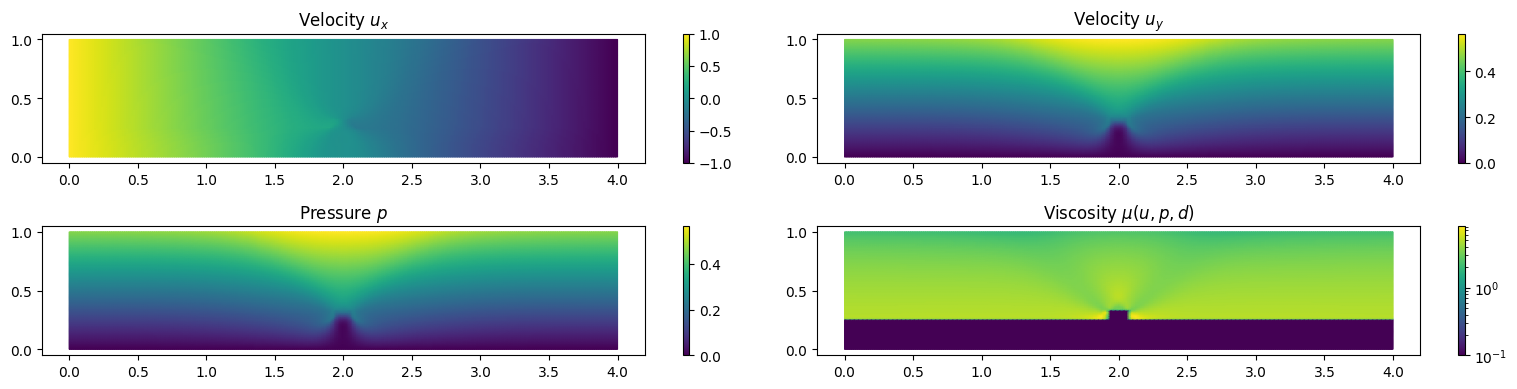

In [15]:
import matplotlib.pyplot as plt

mu_f = Function(W).interpolate(mu)
u_, p_ = z.subfunctions

fig, axes = plt.subplots(2, 2, figsize=(16, 4))

c = tripcolor(u_.sub(0), axes=axes[0, 0])
fig.colorbar(c, ax=axes[0, 0])
axes[0,0].set_title('Velocity $u_x$')

c = tripcolor(u_.sub(1), axes=axes[0, 1])
fig.colorbar(c, ax=axes[0, 1])
axes[0,1].set_title('Velocity $u_y$')

c = tripcolor(u_.sub(1), axes=axes[1, 0])
fig.colorbar(c, ax=axes[1, 0])
axes[1,0].set_title('Pressure $p$')

c = tripcolor(mu_f, axes=axes[1, 1], norm='log')
fig.colorbar(c, ax=axes[1, 1])
axes[1,1].set_title(r'Viscosity $\mu(u, p , d)$');

fig.tight_layout()

For testing purposes, ensuring that our demos remain valid through various
updates to G-ADOPT, we also write some statistics to a `param.log` file:

In [16]:
gd = GeodynamicalDiagnostics(z)
plog = ParameterLog('params.log', mesh)
plog.log_str("u_rms ux_max")
plog.log_str(f"{gd.u_rms()} {gd.ux_max()}")
plog.close()

Exercise
--------
The case above still has a relatively small viscosity contrast between the
two layers. We can make this case more challenging by increasing $\mu_1$.
Increasing the inflow velocity $U_0$, also makes the equations harder to
solve.  Look up table 2 from [Spiegelman et al.
(2016)](https://doi.org/10.1002/2015GC006228) for some suggestions.

Newton Stabilisation
--------------------
As also briefly discussed in [Davies et al.
(2022)](https://doi.org/10.5194/gmd-15-5127-2022), for the most challenging
cases, convergence of the Newton solver is not necessarily stable, even with
an initial guess from the Picard iteration. To stabilize it, the paper
follows an approach from [Fraters et al.
(2019)](https://doi.org/10.1093/gji/ggz183) to modify the Jacobian used in
the Newton solve, and demonstrates it can be implemented in a few lines of
code in G-ADOPT. A user wishing to use this approach is referred to the code
available in one of the G-ADOPT test cases:
`tests/Drucker-Prager_rheology/spiegelman.py`, available in the G-ADOPT
repository.